<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/Residual_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Module

## Introduction

In this notebook, we explore the training of a neural network using residual modules. Residual modules, inspired by residual learning, address the vanishing gradient problem and improve the network's ability to capture complex patterns. By implementing and integrating these modules, we aim to enhance the network's performance and showcase their effectiveness in deep learning architectures.

## How it works

Residual modules are based on the introduction of a shortcut connections that allow information to bypass certain layers in the network. Instead of solely relying on the output of the previous layer, residual modules incorporate the original input data as well. By adding the input data to the output of a layer, the module enables the network to learn residual functions that focus on the differences between the input and output. 
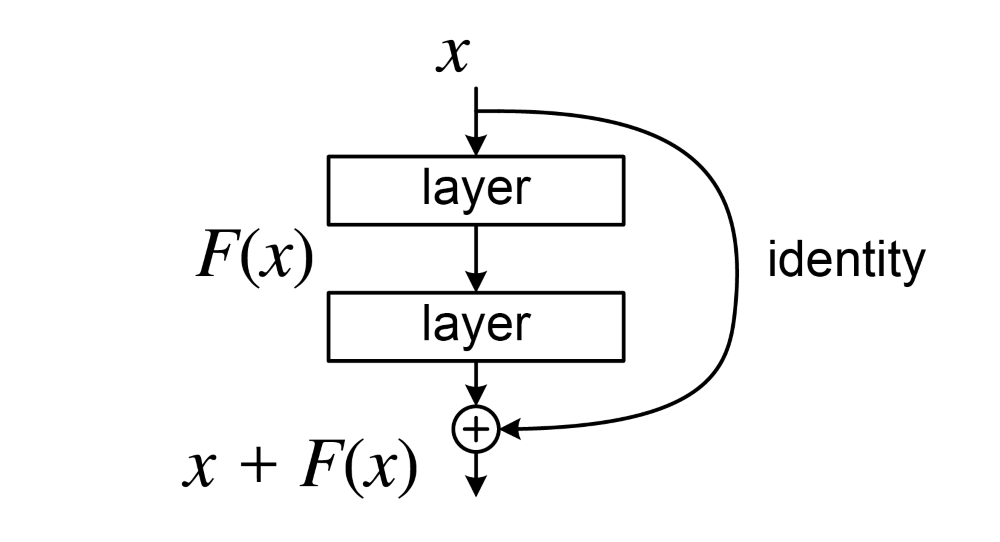

This approach facilitates the learning process, especially when dealing with deep networks, by mitigating the vanishing gradient problem. Residual modules have proven effective in improving gradient flow, enhancing feature extraction, and enabling better model optimization, ultimately leading to improved performance in various tasks.


#Setup

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime
from keras.utils import plot_model

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/
replace /content/dataset/content/splitted_dataset/validation_set/clothes/shoes1263.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

# Residual Module implementation 

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

In [ ]:
def residual_module(layer_in, filters):
 merge_input = layer_in

 if layer_in.shape[-1] != filters:
  merge_input = layers.Conv2D(filters, (1,1), padding='same', activation='relu')(layer_in)

 conv1 = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(layer_in)
 conv2 = layers.Conv2D(filters, (3,3), padding='same', activation='linear')(conv1)

 layer_out = layers.add([conv2, merge_input])
 layer_out = layers.Activation('relu')(layer_out)
 return layer_out

## Model definition

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 conv2d_193 (Conv2D)            (None, 224, 224, 32  896         ['sequential_3[0][0]']           
                                )                                                                 
                                                                                           

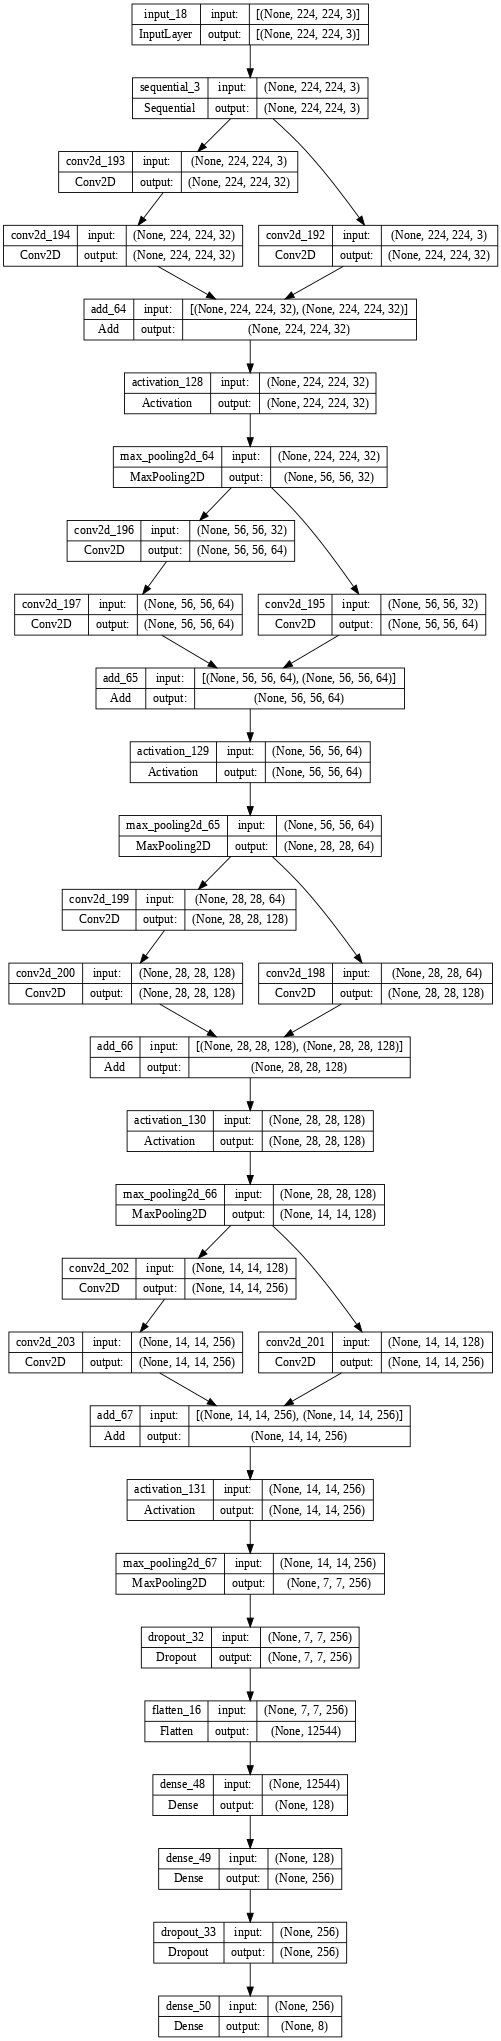

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = residual_module(x, 32)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)
x = residual_module(x, 64)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module(x, 128)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module(x, 256)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "residual_module"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'residual_module.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.8448 - accuracy: 0.2839
Epoch 1: val_loss improved from inf to 1.69156, saving model to /content/drive/My Drive/project/models/residual_module/residual_module.h5
55/55 [==============================] - 43s 636ms/step - loss: 1.8448 - accuracy: 0.2839 - val_loss: 1.6916 - val_accuracy: 0.3765
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.5071 - accuracy: 0.4476
Epoch 2: val_loss improved from 1.69156 to 1.41320, saving model to /content/drive/My Drive/project/models/residual_module/residual_module.h5
55/55 [==============================] - 37s 634ms/step - loss: 1.5071 - accuracy: 0.4476 - val_loss: 1.4132 - val_accuracy: 0.5127
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3539 - accuracy: 0.5195
Epoch 3: val_loss improved from 1.41320 to 1.27526, saving model to /content/drive/My Drive/project/models/residual_module/residual_module.h5
55/55 [======================

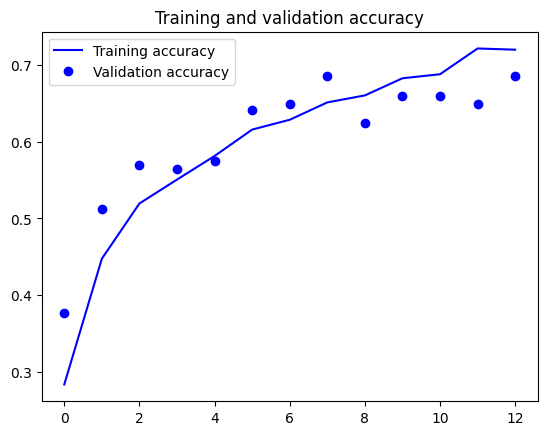

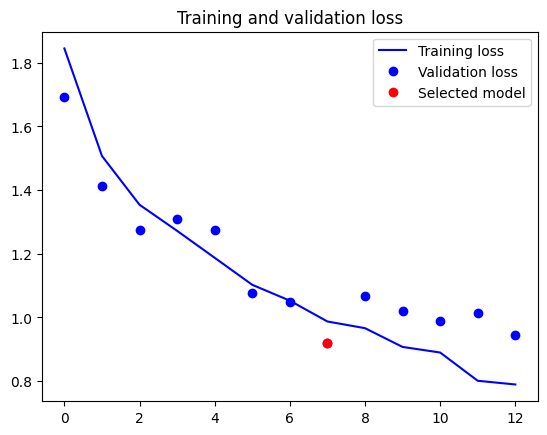

Lowest validation loss has been reached at epoch 7 with validation accuracy of 0.686


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 5s 254ms/step - loss: 0.8782 - accuracy: 0.6881
Test accuracy: 0.688, test loss: 0.878
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 3 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.1340    0.7075    0.2254       147
           1     0.9421    0.7320    0.8239      1112
           2     0.7613    0.4083    0.5315       289
           3     0.3152    0.2959    0.3053        98
           4     0.7000    0.6364    0.6667       165
           5     0.7857    0.4583    0.5789       288
           6     0.5200    0.2977    0.3786       131
           7     0.8125    0.3980    0.5342        98

    accuracy                         0.5928      2328
   macro avg     0.6214    0.4918    0.5056      2328
weighted avg     0.7765    0.5928    0.6493      2328



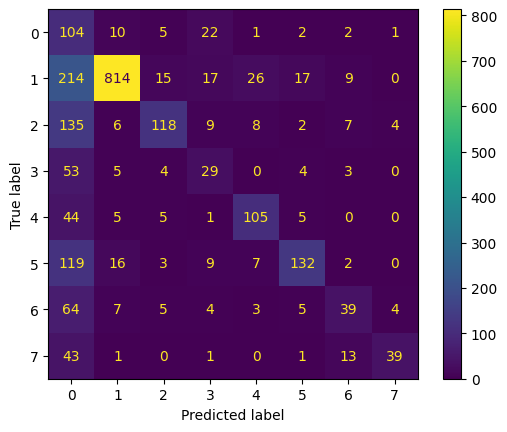

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

# Residual Module implementation with skip connections

In [ ]:
def residual_module_skip(layer_in, filters, use_skip=True, strides=1, activation='relu'):
 skip = layer_in

 if layer_in.shape[-1] != filters:
  skip = layers.Conv2D(filters, (1,1), padding='same', activation=activation)(layer_in)

 conv1 = layers.Conv2D(filters, (3,3), strides=strides, padding='same', activation=activation)(layer_in)
 conv2 = layers.Conv2D(filters, (3,3), strides=1, padding='same', activation=activation)(conv1)

 if use_skip:
  if strides > 1:
    skip = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False)(skip)

 layer_out = layers.add([conv2, skip])
 layer_out = layers.Activation(activation)(layer_out)
 return layer_out

## Model definition

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 224, 224, 32  896         ['sequential_1[1][0]']           
                                )                                                                 
                                                                                            

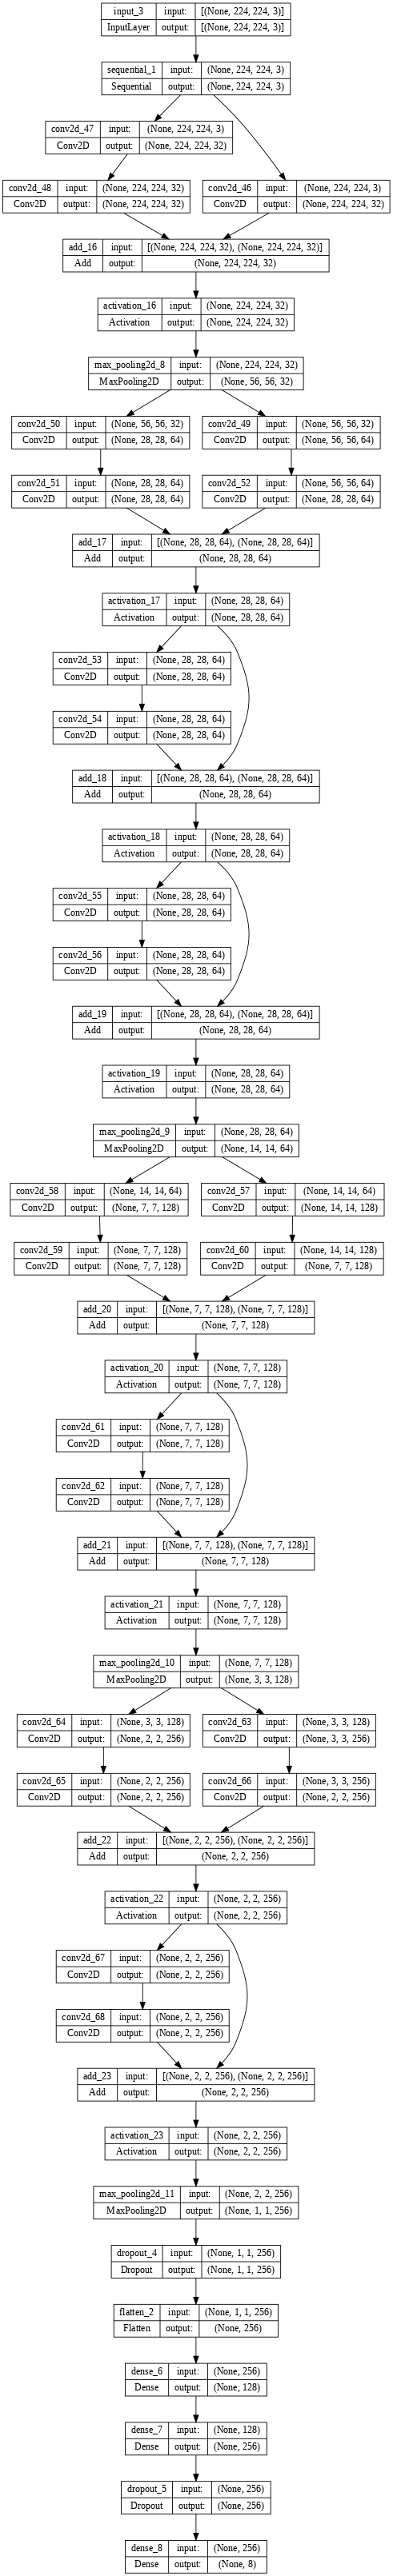

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = residual_module_skip(x, 32)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)
x = residual_module_skip(x, 64, strides=2)
x = residual_module_skip(x, 64)
x = residual_module_skip(x, 64)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module_skip(x, 128, strides=2)
x = residual_module_skip(x, 128)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = residual_module_skip(x, 256, strides=2)
x = residual_module_skip(x, 256)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model_name = "residual_module_skip"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'residual_module_skip.png')

if not os.path.exists(model_path):
  os.makedirs(model_path)

plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.9638 - accuracy: 0.2249
Epoch 1: val_loss improved from inf to 1.85754, saving model to /content/drive/My Drive/project/models/residual_module_skip/residual_module_skip.h5
55/55 [==============================] - 60s 589ms/step - loss: 1.9638 - accuracy: 0.2249 - val_loss: 1.8575 - val_accuracy: 0.2643
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.6655 - accuracy: 0.3597
Epoch 2: val_loss improved from 1.85754 to 1.75883, saving model to /content/drive/My Drive/project/models/residual_module_skip/residual_module_skip.h5
55/55 [==============================] - 34s 574ms/step - loss: 1.6655 - accuracy: 0.3597 - val_loss: 1.7588 - val_accuracy: 0.3133
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.5351 - accuracy: 0.4308
Epoch 3: val_loss improved from 1.75883 to 1.47463, saving model to /content/drive/My Drive/project/models/residual_module_skip/residual_module_skip.h5

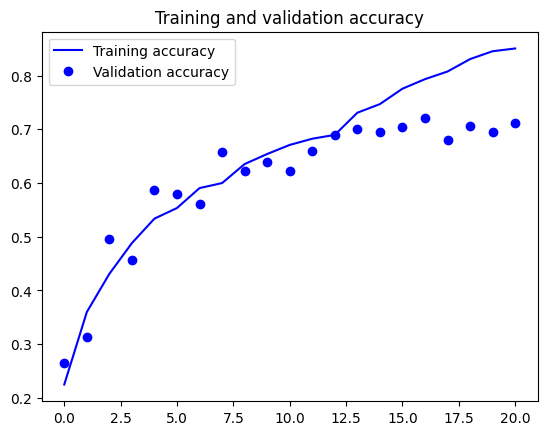

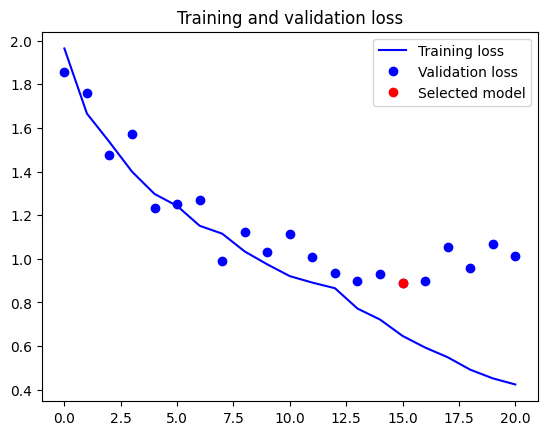

Lowest validation loss has been reached at epoch 15 with validation accuracy of 0.704


In [ ]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 4s 177ms/step - loss: 0.8252 - accuracy: 0.7229
Test accuracy: 0.723, test loss: 0.825
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 3 0]
              precision    recall  f1-score   support

           0     0.2373    0.8231    0.3683       147
           1     0.9356    0.7707    0.8452      1112
           2     0.9558    0.3737    0.5373       289
           3     0.4362    0.4184    0.4271        98
           4     0.5939    0.8242    0.6904       165
           5     0.6569    0.6979    0.6768       288
           6     0.6438    0.3588    0.4608       131
           7     0.7011    0.6224    0.6595        98

    accuracy                         0.6753      2328
   macro avg     0.6451    0.6112    0.5832      2328
weighted avg     0.7880    0.6753    0.6980      2328



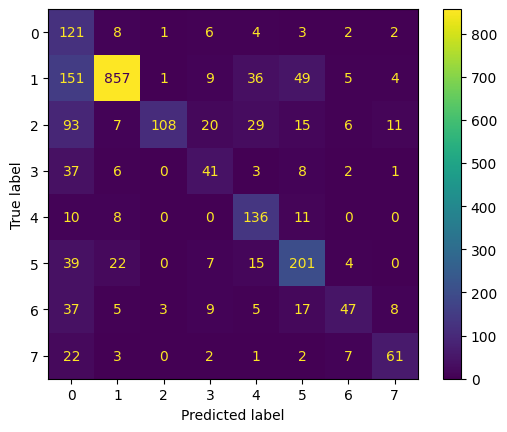

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

#Hyperparameter tuning

## Setup

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

my_dir = "/content/drive/My Drive/tuner"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

## Model builder

In [ ]:
def model_builder(hp):
  # Hyperparameter 
  activation_hp = hp.Choice('activation_function', values=['relu', 'elu', 'gelu'])
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  dropout_rate_hp1 = hp.Float('dropout_rate1', min_value = 0, max_value = 0.5)
  dropout_rate_hp2 = hp.Float('dropout_rate2', min_value = 0, max_value = 0.5)

  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  x = resize_and_rescale(inputs)
  x = residual_module_skip(x, 32, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(4, 4))(x)
  x = residual_module_skip(x, 64, strides=2, activation=activation_hp)
  x = residual_module_skip(x, 64, activation=activation_hp)
  x = residual_module_skip(x, 64, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = residual_module_skip(x, 128, strides=2, activation=activation_hp)
  x = residual_module_skip(x, 128, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = residual_module_skip(x, 256, strides=2, activation=activation_hp)
  x = residual_module_skip(x, 256, activation=activation_hp)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Dropout(dropout_rate_hp1)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(hp_units1)(x)
  x = layers.Dense(hp_units2)(x)
  x = layers.Dropout(dropout_rate_hp2)(x)

  outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='residual_module_hptuning')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

## Instantiate the tuner and perform hyperparameter tuning

In [ ]:
stop_early = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=25,
                     factor=3,
                     directory=log_dir,
                     project_name='model_tuned')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'gelu'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dropout_rate2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}


Perform search for the best hyperparameters. 

In [ ]:
tuner.search(train_dataset, epochs=25, validation_data=validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units1')}, \
        The optimal number of units in the second densely-connected layer is {best_hps.get('units2')}, \
        The optimal activation function is {best_hps.get('activation_function')}, \
        The optimal first dropout value is  {best_hps.get('dropout_rate1')}, \
        The optimal second dropout value is  {best_hps.get('dropout_rate2')}, \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 192,         The optimal number of units in the second densely-connected layer is 352,         The optimal activation function is relu,         The optimal first dropout value is  0.45443640433752847,         The optimal second dropout value is  0.21661425812447588,         the optimal learning rate for the optimizer is 0.001.


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/My Drive/tuner/logs/0511-1051/model_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0023 summary
Hyperparameters:
activation_function: relu
units1: 192
units2: 352
learning_rate: 0.001
dropout_rate1: 0.45443640433752847
dropout_rate2: 0.21661425812447588
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7271164655685425

Trial 0014 summary
Hyperparameters:
activation_function: elu
units1: 32
units2: 416
learning_rate: 0.001
dropout_rate1: 0.13306433093830422
dropout_rate2: 0.2573586672275882
tuner/epochs: 9
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0002
Score: 0.7137945890426636

Trial 0025 summary
Hyperparameters:
activation_function: relu
units1: 192
units2: 224
learning_rate: 0.001
dropout_rate1: 0.32260858574851803
dropout_rate2: 0.06638715879915658
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7120756506919861


## Train model with the best hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=stop_early)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - 42s 574ms/step - loss: 1.9570 - accuracy: 0.2217 - val_loss: 1.9729 - val_accuracy: 0.2359
Epoch 2/50
55/55 [==============================] - 31s 542ms/step - loss: 1.7669 - accuracy: 0.3395 - val_loss: 1.7805 - val_accuracy: 0.4022
Epoch 3/50
55/55 [==============================] - 31s 554ms/step - loss: 1.5523 - accuracy: 0.4268 - val_loss: 1.5493 - val_accuracy: 0.4633
Epoch 4/50
55/55 [==============================] - 33s 574ms/step - loss: 1.4308 - accuracy: 0.4855 - val_loss: 1.4207 - val_accuracy: 0.4843
Epoch 5/50
55/55 [==============================] - 31s 554ms/step - loss: 1.2555 - accuracy: 0.5490 - val_loss: 1.1152 - val_accuracy: 0.6214
Epoch 6/50
55/55 [==============================] - 31s 548ms/step - loss: 1.1108 - accuracy: 0.6081 - val_loss: 1.1119 - val_accuracy: 0.6081
Epoch 7/50
55/55 [==============================] - 32s 569ms/step - loss: 0.9937 - accuracy: 0.6538 - val_loss: 1.0686 - val_accuracy: 0.6394
Epoch 8/50

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_dataset, epochs=best_epoch, validation_data=validation_dataset, callbacks=stop_early)

Epoch 1/12
55/55 [==============================] - 40s 556ms/step - loss: 2.0328 - accuracy: 0.1781 - val_loss: 1.9638 - val_accuracy: 0.1934
Epoch 2/12
55/55 [==============================] - 32s 566ms/step - loss: 1.7585 - accuracy: 0.3283 - val_loss: 1.6286 - val_accuracy: 0.4422
Epoch 3/12
55/55 [==============================] - 32s 554ms/step - loss: 1.5857 - accuracy: 0.4192 - val_loss: 1.6149 - val_accuracy: 0.3911
Epoch 4/12
55/55 [==============================] - 31s 549ms/step - loss: 1.3961 - accuracy: 0.4933 - val_loss: 1.5058 - val_accuracy: 0.4899
Epoch 5/12
55/55 [==============================] - 31s 550ms/step - loss: 1.2658 - accuracy: 0.5510 - val_loss: 1.5215 - val_accuracy: 0.4602
Epoch 6/12
55/55 [==============================] - 34s 581ms/step - loss: 1.1590 - accuracy: 0.5895 - val_loss: 1.0583 - val_accuracy: 0.6386
Epoch 7/12
55/55 [==============================] - 32s 571ms/step - loss: 1.0520 - accuracy: 0.6298 - val_loss: 0.9519 - val_accuracy: 0.6786

In [ ]:
eval_result = hypermodel.evaluate(test_dataset)
print("[test loss, test accuracy]:", eval_result)

19/19 [==============================] - 5s 259ms/step - loss: 0.8953 - accuracy: 0.7251
[test loss, test accuracy]: [0.895256757736206, 0.7250859141349792]
